In [14]:
import glob
import json
import math
import os
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from IPython.display import Image, display
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

# --- Constants from original notebook ---
# File paths
SAVED_MODEL_FILENAME = "saved_model_0_1"  # Modified for 2-digit version
FLOAT_TFL_MODEL_FILENAME = "float_model_0_1.tfl"
QUANTIZED_TFL_MODEL_FILENAME = "quantized_model_0_1.tfl"
TFL_CC_MODEL_FILENAME = "magic_wand_model_data_0_1.cc"

# Image properties
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUM_CHANNELS = 3  # RGB, due to color encoding of time in rasterization

# Fixed-point arithmetic (for rasterization)
FIXED_POINT = 4096

# Data ranges for rasterization
X_RANGE = 0.6  # Max expected x-coordinate deviation from center
Y_RANGE = 0.6  # Max expected y-coordinate deviation from center

# --- New constants for this version ---
TARGET_LABELS = ["0", "1"]
NUM_CLASSES = len(TARGET_LABELS)

# Ensure output directories for models exist
Path("checkpoints").mkdir(parents=True, exist_ok=True)

print(f"TensorFlow Version: {tf.__version__}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Target labels: {TARGET_LABELS}")

TensorFlow Version: 2.19.0
Number of classes: 2
Target labels: ['0', '1']


In [15]:
strokes = []
# Assuming your data is in a 'data' subdirectory relative to the notebook
# If your JSON files are named like '0.json', '1.json', etc.
# and these names directly correspond to the labels.
# Modify glob pattern if your files are named differently.

# Create dummy data if it doesn't exist for demonstration
Path("data").mkdir(parents=True, exist_ok=True)

for filename in glob.glob("data/*.json"):
    with open(filename, "r") as file:
        file_contents = file.read()
    try:
        file_data = json.loads(file_contents)
        for stroke_idx, stroke in enumerate(file_data["strokes"]):
            stroke["filename"] = filename
            # Ensure 'index' exists, if not, use enumeration
            if "index" not in stroke:
                stroke["index"] = stroke_idx
            strokes.append(stroke)
    except json.JSONDecodeError:
        print(f"Warning: Could not decode JSON from {filename}")
    except KeyError:
        print(f"Warning: 'strokes' key not found in {filename}")

print(f"Total strokes loaded: {len(strokes)}")

# Filter for target labels
filtered_strokes = [
    s for s in strokes if str(s.get("label", "")).strip() in TARGET_LABELS
]

print(f"Strokes after filtering for {TARGET_LABELS}: {len(filtered_strokes)}")

# Basic check for stroke points
valid_strokes = []
for stroke in filtered_strokes:
    if "strokePoints" in stroke and len(stroke["strokePoints"]) > 1:
        valid_strokes.append(stroke)
    else:
        print(
            f"Warning: Stroke from {stroke['filename']} (label: {stroke['label']}) "
            "has insufficient points and will be skipped."
        )
strokes = valid_strokes
print(f"Valid strokes for training/testing: {len(strokes)}")

if not strokes:
    raise ValueError(
        "No valid strokes found for the target labels. "
        "Please check your data directory and JSON structure."
    )

# Analyze stroke lengths (optional, but good for understanding)
if strokes:
    func = lambda x: len(x["strokePoints"])
    values = list(map(func, strokes))
    print(
        f"Stroke lengths for filtered data: "
        f"min {np.min(values)}, max {np.max(values)}, "
        f"avg {np.average(values):.2f}"
    )
else:
    print("No strokes to analyze.")

Total strokes loaded: 200
Strokes after filtering for ['0', '1']: 200
Valid strokes for training/testing: 200
Stroke lengths for filtered data: min 56, max 160, avg 74.00


Plotting sample for label: 1


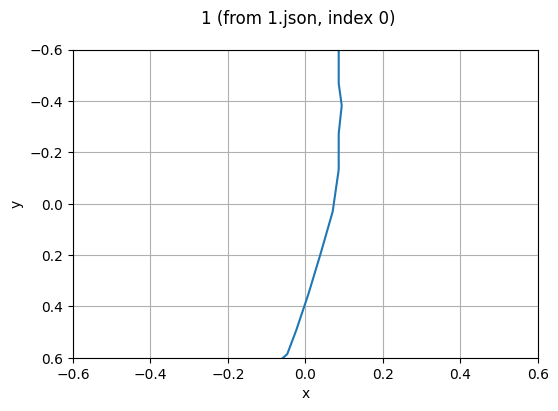

Plotting sample for label: 0


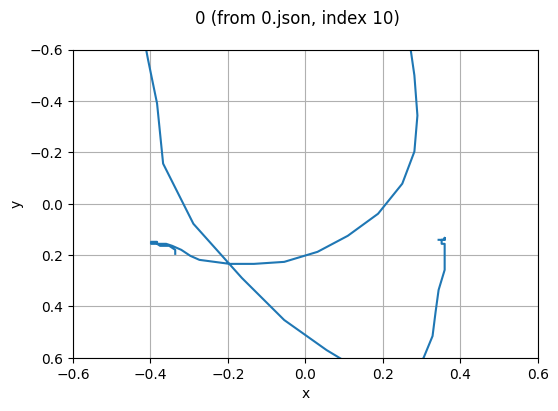

In [16]:
def plot_stroke(stroke):
    """Plots a single stroke."""
    x_array = []
    y_array = []
    if "strokePoints" not in stroke or not stroke["strokePoints"]:
        print(f"Stroke has no points: {stroke.get('label', 'N/A')}")
        return

    for coords in stroke["strokePoints"]:
        x_array.append(coords["x"])
        y_array.append(coords["y"])

    fig = plt.figure(figsize=(6, 4))  # Adjusted size
    title = str(stroke.get("label", "Unknown Label"))
    if "filename" in stroke and "index" in stroke:
        title += f" (from {Path(stroke['filename']).name}, index {stroke['index']})"
    fig.suptitle(title)

    ax = fig.add_subplot(111)  # Simpler subplot
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    # Dynamically set limits or use fixed ones from original
    ax.set_xlim(-X_RANGE, X_RANGE)
    ax.set_ylim(-Y_RANGE, Y_RANGE)
    ax.plot(x_array, y_array)
    ax.invert_yaxis()  # Often intuitive for drawing
    plt.grid(True)
    plt.show()


# Plot one example of each target label, if available
if strokes:
    plotted_labels = set()
    for stroke_to_plot in np.random.permutation(strokes):
        label = str(stroke_to_plot.get("label", "")).strip()
        if label in TARGET_LABELS and label not in plotted_labels:
            print(f"Plotting sample for label: {label}")
            plot_stroke(stroke_to_plot)
            plotted_labels.add(label)
        if len(plotted_labels) == NUM_CLASSES:
            break
    if len(plotted_labels) < NUM_CLASSES:
        print("Warning: Could not find samples for all target labels to plot.")
else:
    print("No strokes available to plot.")

Rasterizing a sample stroke: Label 1


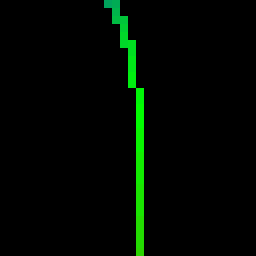

In [17]:
# Fixed-point arithmetic functions (from original notebook)
def mul_fp(a, b):
    return (a * b) // FIXED_POINT


def div_fp(a, b):
    if b == 0:
        b = 1  # Avoid division by zero
    return (a * FIXED_POINT) // b


def float_to_fp(a):
    return math.floor(a * FIXED_POINT)


def norm_to_coord_fp(a, range_fp, half_size_fp):
    a_fp = float_to_fp(a)
    norm_fp = div_fp(a_fp, range_fp)
    return mul_fp(norm_fp, half_size_fp) + half_size_fp


def round_fp_to_int(a):
    return math.floor((a + (FIXED_POINT // 2)) / FIXED_POINT)


def gate(a, min_val, max_val):
    if a < min_val:
        return min_val
    elif a > max_val:
        return max_val
    else:
        return a


def rasterize_stroke(stroke_points, x_range, y_range, width, height):
    """
    Rasterizes stroke points into an image buffer with time encoded as color.
    x_range: The expected maximum deviation of x-coordinates from the center (e.g., 0.5 means coords range from -0.5 to 0.5)
    y_range: Similar for y-coordinates.
    width: Output image width in pixels.
    height: Output image height in pixels.
    """
    if not stroke_points or len(stroke_points) < 2:
        # Return a blank image if not enough points
        return np.zeros((height, width, NUM_CHANNELS), dtype=np.uint8)

    buffer_byte_count = height * width * NUM_CHANNELS
    buffer = bytearray(buffer_byte_count)  # Initialize with zeros (black)

    width_fp = float_to_fp(width)  # Use float_to_fp for consistency
    height_fp = float_to_fp(height)
    half_width_fp = width_fp // 2
    half_height_fp = height_fp // 2
    x_range_fp = float_to_fp(x_range)
    y_range_fp = float_to_fp(y_range)

    # Ensure t_inc_fp is not zero
    num_segments = len(stroke_points) - 1
    if num_segments == 0:  # single point, can't draw lines
        # Optionally draw a single point or return blank
        return np.frombuffer(buffer, dtype=np.uint8).reshape(
            height, width, NUM_CHANNELS
        )

    t_inc_fp = FIXED_POINT // num_segments if num_segments > 0 else FIXED_POINT

    one_half_fp = FIXED_POINT // 2

    for point_index in range(num_segments):
        start_point = stroke_points[point_index]
        end_point = stroke_points[point_index + 1]

        # Normalize coordinates and scale to image dimensions using fixed point
        # Y is often inverted in screen coordinates vs. array indexing.
        # The original used -start_point["y"], so we keep that.
        start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
        start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
        end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
        end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)

        delta_x_fp = end_x_fp - start_x_fp
        delta_y_fp = end_y_fp - start_y_fp

        # Determine color based on progress through the stroke
        t_fp = point_index * t_inc_fp
        if t_fp < one_half_fp:
            local_t_fp = div_fp(t_fp, one_half_fp)
            one_minus_t_fp = FIXED_POINT - local_t_fp
            red = round_fp_to_int(mul_fp(one_minus_t_fp, float_to_fp(255)))
            green = round_fp_to_int(mul_fp(local_t_fp, float_to_fp(255)))
            blue = 0
        else:
            local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
            one_minus_t_fp = FIXED_POINT - local_t_fp
            red = 0
            green = round_fp_to_int(mul_fp(one_minus_t_fp, float_to_fp(255)))
            blue = round_fp_to_int(mul_fp(local_t_fp, float_to_fp(255)))

        red = gate(red, 0, 255)
        green = gate(green, 0, 255)
        blue = gate(blue, 0, 255)

        # Line drawing algorithm (Bresenham's-like logic for fixed point)
        if abs(delta_x_fp) > abs(delta_y_fp):  # Iterate along x-axis
            line_length = abs(round_fp_to_int(delta_x_fp))
            if line_length == 0:
                continue
            if delta_x_fp > 0:
                x_inc_fp = float_to_fp(1.0)
                y_inc_fp = div_fp(delta_y_fp, delta_x_fp)  # y_inc per unit x_inc
            else:
                x_inc_fp = float_to_fp(-1.0)
                y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)  # Corrected sign
        else:  # Iterate along y-axis
            line_length = abs(round_fp_to_int(delta_y_fp))
            if line_length == 0:
                continue
            if delta_y_fp > 0:
                y_inc_fp = float_to_fp(1.0)
                x_inc_fp = div_fp(delta_x_fp, delta_y_fp)  # x_inc per unit y_inc
            else:
                y_inc_fp = float_to_fp(-1.0)
                x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)  # Corrected sign

        for i in range(line_length + 1):
            current_x_fp = start_x_fp + mul_fp(
                float_to_fp(i),
                x_inc_fp if abs(delta_x_fp) > abs(delta_y_fp) else x_inc_fp,
            )
            current_y_fp = start_y_fp + mul_fp(
                float_to_fp(i),
                y_inc_fp if abs(delta_x_fp) > abs(delta_y_fp) else y_inc_fp,
            )

            # For the case where we iterate along y:
            if abs(delta_y_fp) >= abs(delta_x_fp):
                current_x_fp = start_x_fp + mul_fp(float_to_fp(i), x_inc_fp)
                current_y_fp = start_y_fp + mul_fp(float_to_fp(i), y_inc_fp)

            x = round_fp_to_int(current_x_fp)
            y = round_fp_to_int(current_y_fp)

            if (x < 0) or (x >= width) or (y < 0) or (y >= height):
                continue

            buffer_index = (y * width * NUM_CHANNELS) + (x * NUM_CHANNELS)
            if buffer_index + 2 < len(buffer):  # Ensure we are within bounds
                buffer[buffer_index + 0] = red
                buffer[buffer_index + 1] = green
                buffer[buffer_index + 2] = blue

    np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(
        height, width, NUM_CHANNELS
    )
    return np_buffer


# Test rasterization
if strokes:
    sample_stroke_for_raster = np.random.choice(strokes)
    print(f"Rasterizing a sample stroke: Label {sample_stroke_for_raster['label']}")
    raster = rasterize_stroke(
        sample_stroke_for_raster["strokePoints"],
        X_RANGE,
        Y_RANGE,
        IMAGE_WIDTH,
        IMAGE_HEIGHT,
    )
    img = PIL.Image.fromarray(raster).resize(
        (256, 256), PIL.Image.NEAREST
    )  # Upscale for viewing
    display(img)
else:
    print("No strokes to test rasterization.")

In [18]:
def ensure_empty_dir(dirname):
    dirpath = Path(dirname)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)
    dirpath.mkdir(
        parents=True, exist_ok=False
    )  # parents=True in case root_folder doesn't exist


def augment_points(points, move_range, scale_range, rotate_range):
    """Applies random translation, scaling, and rotation to stroke points."""
    move_x = np.random.uniform(low=-move_range, high=move_range)
    move_y = np.random.uniform(low=-move_range, high=move_range)
    scale = np.random.uniform(low=1.0 - scale_range, high=1.0 + scale_range)
    rotate = np.random.uniform(low=-rotate_range, high=rotate_range)

    cos_rot = math.cos(rotate)
    sin_rot = math.sin(rotate)

    x_axis_x = cos_rot * scale
    x_axis_y = sin_rot * scale
    y_axis_x = -sin_rot * scale
    y_axis_y = cos_rot * scale

    new_points = []
    for point in points:
        old_x = point["x"]
        old_y = point["y"]
        # Apply rotation and scale first, then translation
        rotated_scaled_x = (x_axis_x * old_x) + (
            y_axis_x * old_y
        )  # Typo in original: x_axis_y should be y_axis_x for y component
        rotated_scaled_y = (x_axis_y * old_x) + (
            y_axis_y * old_y
        )  # Typo in original: y_axis_x should be x_axis_y for x component
        # Corrected:
        rotated_scaled_x = (cos_rot * old_x - sin_rot * old_y) * scale
        rotated_scaled_y = (sin_rot * old_x + cos_rot * old_y) * scale

        new_x = rotated_scaled_x + move_x
        new_y = rotated_scaled_y + move_y
        new_points.append({"x": new_x, "y": new_y})
    return new_points


def save_strokes_as_images(
    strokes_list, root_folder, width, height, augment_count_per_image
):
    """
    Saves strokes as PNG images, organized into subfolders by label.
    Applies augmentation to increase dataset size.
    """
    ensure_empty_dir(root_folder)
    # Create subdirectories for each label in TARGET_LABELS
    for label_str in TARGET_LABELS:
        label_path = Path(root_folder, label_str)
        ensure_empty_dir(label_path)  # ensure_empty_dir handles creation

    label_counts = {label_str: 0 for label_str in TARGET_LABELS}

    for stroke in strokes_list:
        points = stroke["strokePoints"]
        label = str(stroke["label"]).strip().lower()  # Normalize label

        if label not in TARGET_LABELS:  # Should not happen if pre-filtered
            print(f"Skipping stroke with unexpected label: {label}")
            continue

        if (
            not points or len(points) < 2
        ):  # Need at least 2 points to make a line segment
            print(
                f"Skipping stroke {stroke['filename']}:{stroke['index']} due to insufficient points."
            )
            continue

        current_label_count = label_counts[label]
        label_counts[label] += 1

        # Save original rasterized image
        raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
        image = PIL.Image.fromarray(raster)
        image.save(Path(root_folder, label, f"{current_label_count}.png"))

        # Save augmented versions
        for i in range(augment_count_per_image):
            # Original notebook: move_range=0.0, scale_range=0.1, rotate_range=0.3
            # Keeping move_range=0.0 as strokes should be somewhat centered.
            augmented_points = augment_points(
                points, move_range=0.0, scale_range=0.1, rotate_range=0.3
            )
            raster_aug = rasterize_stroke(
                augmented_points, X_RANGE, Y_RANGE, width, height
            )
            image_aug = PIL.Image.fromarray(raster_aug)
            image_aug.save(Path(root_folder, label, f"{current_label_count}_a{i}.png"))

    print(f"Saved images to {root_folder}. Label counts: {label_counts}")


# Shuffle and split data
shuffled_strokes = list(strokes)  # Use the filtered 'strokes'
np.random.shuffle(shuffled_strokes)

# Define dataset split percentages
test_percentage = 20  # Increased for smaller dataset
validation_percentage = 20
train_percentage = 100 - (test_percentage + validation_percentage)

# Calculate counts
total_filtered_strokes = len(shuffled_strokes)
test_count = math.floor((total_filtered_strokes * test_percentage) / 100)
validation_count = math.floor((total_filtered_strokes * validation_percentage) / 100)

# Split
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count : (test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count) :]

print(f"Total strokes for processing: {total_filtered_strokes}")
print(f"Training strokes: {len(train_strokes)}")
print(f"Validation strokes: {len(validation_strokes)}")
print(f"Test strokes: {len(test_strokes)}")

# Define augmentation counts
# More augmentation for training, less or none for validation/test
# Original used 10 for train and test, 0 for validation.
# Let's stick to that for now.
AUGMENT_TRAIN = 10
AUGMENT_VAL = 0  # No augmentation for validation set
AUGMENT_TEST = 0  # Typically no augmentation for test set to get a true measure

# Create the image datasets
if train_strokes:
    save_strokes_as_images(
        train_strokes, "train_0_1", IMAGE_WIDTH, IMAGE_HEIGHT, AUGMENT_TRAIN
    )
else:
    print("No training strokes to save.")
    Path("train_0_1").mkdir(exist_ok=True)  # Create dir anyway for dataset loader

if validation_strokes:
    save_strokes_as_images(
        validation_strokes, "validation_0_1", IMAGE_WIDTH, IMAGE_HEIGHT, AUGMENT_VAL
    )
else:
    print("No validation strokes to save.")
    Path("validation_0_1").mkdir(exist_ok=True)

if test_strokes:
    save_strokes_as_images(
        test_strokes, "test_0_1", IMAGE_WIDTH, IMAGE_HEIGHT, AUGMENT_TEST
    )
else:
    print("No test strokes to save.")
    Path("test_0_1").mkdir(exist_ok=True)

Total strokes for processing: 200
Training strokes: 120
Validation strokes: 40
Test strokes: 40
Saved images to train_0_1. Label counts: {'0': 60, '1': 60}
Saved images to validation_0_1. Label counts: {'0': 20, '1': 20}
Saved images to test_0_1. Label counts: {'0': 20, '1': 20}


Found 1320 files belonging to 2 classes.
Found 40 files belonging to 2 classes.
Found 40 files belonging to 2 classes.
Datasets loaded successfully.
Class names captured: ['0', '1']


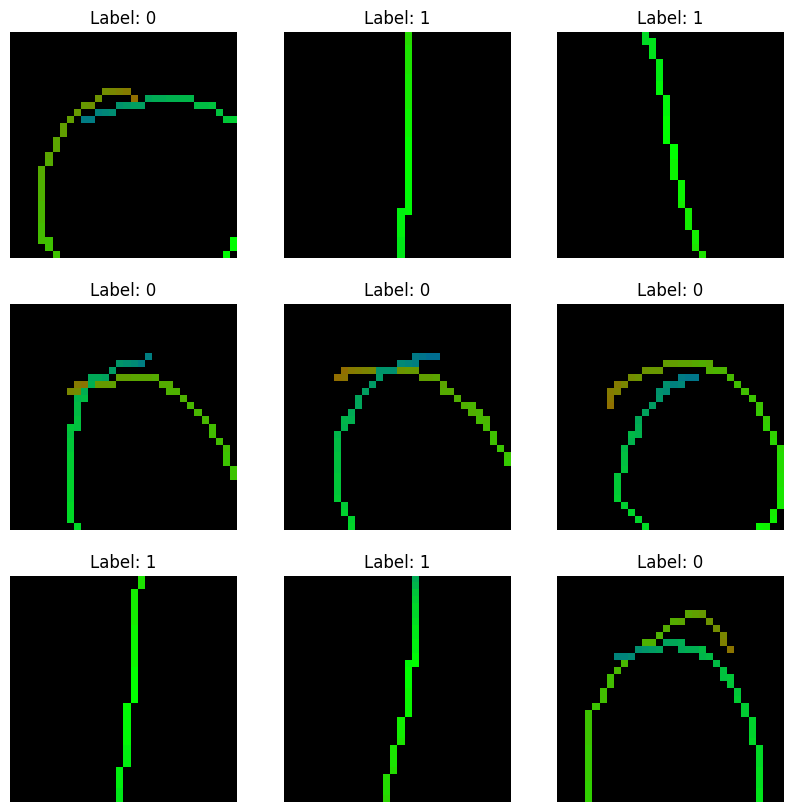

In [19]:
# Create this as a new Jupyter Notebook cell (Code) - MODIFICATION for Step 6

BATCH_SIZE = 32

# Create datasets
for label in TARGET_LABELS:
    Path(f"train_0_1/{label}").mkdir(parents=True, exist_ok=True)
    Path(f"validation_0_1/{label}").mkdir(parents=True, exist_ok=True)
    Path(f"test_0_1/{label}").mkdir(parents=True, exist_ok=True)

# Initialize class_names variable
loaded_class_names = None

try:
    # For train_ds, capture class_names
    train_ds_temp = image_dataset_from_directory(
        directory="train_0_1",
        labels="inferred",
        label_mode="categorical",
        batch_size=BATCH_SIZE,
        image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        shuffle=True,
        seed=123,
    )
    loaded_class_names = train_ds_temp.class_names  # CAPTURE HERE
    train_ds = train_ds_temp.prefetch(buffer_size=tf.data.AUTOTUNE)
    del train_ds_temp  # Clean up temporary dataset

    # For validation_ds, we can assume class names are the same or re-verify
    validation_ds_temp = image_dataset_from_directory(
        directory="validation_0_1",
        labels="inferred",
        label_mode="categorical",
        batch_size=BATCH_SIZE,
        image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        shuffle=False,
    )
    if loaded_class_names and validation_ds_temp.class_names != loaded_class_names:
        print("Warning: Validation class names differ from training!")
    elif not loaded_class_names:
        loaded_class_names = validation_ds_temp.class_names
    validation_ds = validation_ds_temp.prefetch(buffer_size=tf.data.AUTOTUNE)
    del validation_ds_temp

    # For test_ds, similarly
    test_ds_temp = image_dataset_from_directory(
        directory="test_0_1",
        labels="inferred",
        label_mode="categorical",
        batch_size=BATCH_SIZE,
        image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        shuffle=False,
    )
    if loaded_class_names and test_ds_temp.class_names != loaded_class_names:
        print("Warning: Test class names differ from training/validation!")
    elif not loaded_class_names:
        loaded_class_names = test_ds_temp.class_names
    test_ds = test_ds_temp.prefetch(buffer_size=tf.data.AUTOTUNE)
    del test_ds_temp

    if loaded_class_names:
        print("Datasets loaded successfully.")
        print(f"Class names captured: {loaded_class_names}")
        if sorted(loaded_class_names) != sorted(TARGET_LABELS):
            print(
                "Warning: Captured class names do not match TARGET_LABELS!"
                f"Captured: {loaded_class_names}, Target: {TARGET_LABELS}"
            )
    else:
        print("Warning: Could not capture class names during dataset loading.")

    # Visualize a few examples from the training dataset
    if loaded_class_names:  # Only plot if we have class names
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(min(9, images.shape[0])):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                label_index = np.argmax(labels[i])
                plt.title(
                    f"Label: {loaded_class_names[label_index]}"
                )  # Use captured names
                plt.axis("off")
        plt.show()

except Exception as e:
    print(f"Error loading datasets: {e}")
    # ... (rest of the error handling remains the same) ...
    if "train_ds" not in locals():
        print("Creating dummy empty train_ds.")
        train_ds = tf.data.Dataset.from_tensor_slices(
            (
                np.zeros(
                    (0, IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS), dtype=np.float32
                ),
                np.zeros((0, NUM_CLASSES), dtype=np.float32),
            )
        ).batch(BATCH_SIZE)
    if "validation_ds" not in locals():
        print("Creating dummy empty validation_ds.")
        validation_ds = tf.data.Dataset.from_tensor_slices(
            (
                np.zeros(
                    (0, IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS), dtype=np.float32
                ),
                np.zeros((0, NUM_CLASSES), dtype=np.float32),
            )
        ).batch(BATCH_SIZE)
    if "test_ds" not in locals():
        print("Creating dummy empty test_ds.")
        test_ds = tf.data.Dataset.from_tensor_slices(
            (
                np.zeros(
                    (0, IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS), dtype=np.float32
                ),
                np.zeros((0, NUM_CLASSES), dtype=np.float32),
            )
        ).batch(BATCH_SIZE)

In [20]:
def make_model(input_shape, num_classes_local):  # Renamed num_classes to avoid conflict
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)  # Dropout rate can be tuned

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.GlobalAveragePooling2D()(x)

    # Classifier block
    x = layers.Dropout(0.5)(x)  # Dropout before the final dense layer

    # For NUM_CLASSES=2 with 'categorical_crossentropy', output layer should have 2 units and softmax
    activation = "softmax"
    units = num_classes_local

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


# Instantiate the model
model_input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS)
model = make_model(input_shape=model_input_shape, num_classes_local=NUM_CLASSES)

# Display model summary
model.summary()

# Plot the model (optional, but good for visualization)
# You might need to install pydot and graphviz:
# pip install pydot graphviz
try:
    display(keras.utils.plot_model(model, show_shapes=True, expand_nested=True))
except Exception as e:
    print(f"Could not plot model (is pydot/graphviz installed?): {e}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,162 (94.38 KB)

 Trainable params: 23,938 (93.51 KB)

 Non-trainable params: 224 (896.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


None

Starting training for 30 epochs...
Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6156 - loss: 0.6467 - val_accuracy: 0.5000 - val_loss: 0.6895
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9245 - loss: 0.2336 - val_accuracy: 0.5000 - val_loss: 1.1109
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9707 - loss: 0.1227 - val_accuracy: 0.5000 - val_loss: 1.5393
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9930 - loss: 0.0648 - val_accuracy: 0.5000 - val_loss: 1.7606
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9904 - loss: 0.0521 - val_accuracy: 0.5000 - val_loss: 1.8372
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9943 - loss: 0.0431 - val_accuracy: 0.5000 - val_loss: 1.7112
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9946 - loss: 0.0328 - val_accuracy: 0.5000 - val_loss: 1.5022
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9943 - loss: 0.0256

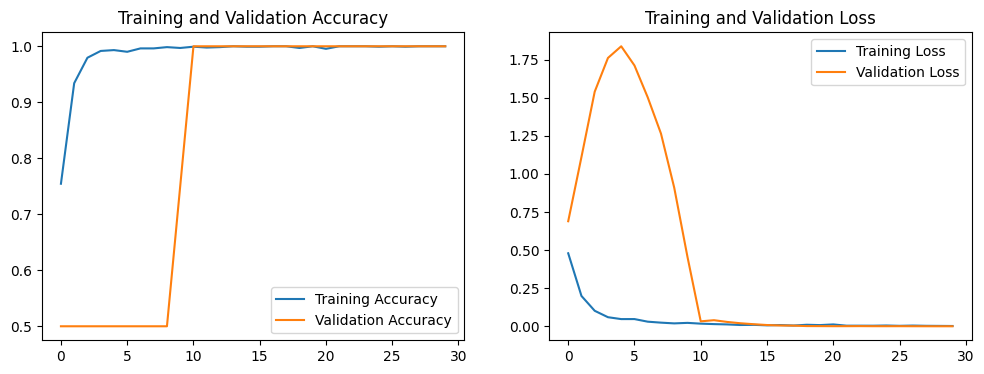

Loading best model from checkpoints/best_model_0_1.keras


In [21]:
EPOCHS = 30  # Start with a moderate number, can be increased
LEARNING_RATE = 1e-3  # 0.001

# Callbacks
# ModelCheckpoint to save the best model during training
checkpoint_filepath = "checkpoints/best_model_0_1.keras"  # Use .keras format
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Save the full model
    monitor="val_accuracy",  # Monitor validation accuracy
    mode="max",  # Mode should be 'max' for accuracy
    save_best_only=True,  # Only save if performance improves
)

# EarlyStopping to prevent overfitting
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restores model weights from the epoch with the best value of the monitored quantity.
)

callbacks_list = [model_checkpoint_callback, early_stopping_callback]

# Compile the model
# For NUM_CLASSES=2 and softmax output, categorical_crossentropy is appropriate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",  # Use categorical_crossentropy for one-hot labels
    metrics=["accuracy"],
)

# Check if training data is available
# train_ds.cardinality() returns the number of batches. tf.data.UNKNOWN_CARDINALITY if it's infinite or can't be determined.
# train_ds.reduce(0, lambda x, _: x + 1) would count elements but can be slow for large datasets.
# A simple check is to see if we can take at least one batch.
try:
    _ = next(iter(train_ds))
    has_train_data = True
except StopIteration:
    has_train_data = False

if has_train_data:
    print(f"Starting training for {EPOCHS} epochs...")
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        callbacks=callbacks_list,
        validation_data=validation_ds,
    )

    # Plot training history
    if history and history.history:
        acc = history.history["accuracy"]
        val_acc = history.history["val_accuracy"]
        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        epochs_range = range(len(acc))

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label="Training Accuracy")
        plt.plot(epochs_range, val_acc, label="Validation Accuracy")
        plt.legend(loc="lower right")
        plt.title("Training and Validation Accuracy")

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label="Training Loss")
        plt.plot(epochs_range, val_loss, label="Validation Loss")
        plt.legend(loc="upper right")
        plt.title("Training and Validation Loss")
        plt.show()
else:
    print("Skipping training as no training data was found or loaded.")
    history = None  # Ensure history object exists

# Load the best model saved by ModelCheckpoint
if os.path.exists(checkpoint_filepath) and has_train_data:
    print(f"Loading best model from {checkpoint_filepath}")
    model = keras.models.load_model(checkpoint_filepath)
else:
    print(
        "Best model checkpoint not found or training was skipped. Using the model from the last training epoch (if any)."
    )

In [22]:
# Check if test data is available
try:
    _ = next(iter(test_ds))
    has_test_data = True
except StopIteration:
    has_test_data = False

if has_test_data:
    print("Evaluating model on the test dataset...")
    loss, accuracy = model.evaluate(test_ds)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
else:
    print("Skipping evaluation as no test data was found or loaded.")
    accuracy = 0.0  # Default if no test data


# Prediction function (similar to original, adapted for tf.data.Dataset)
def predict_image_keras(
    keras_model, image_path, class_names_list_param
):  # Renamed param
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = keras_model.predict(img_array, verbose=0).flatten()
    predicted_label_index = np.argmax(predictions)
    predicted_score = predictions[predicted_label_index]
    # Ensure class_names_list_param is valid and index is within bounds
    if class_names_list_param and 0 <= predicted_label_index < len(
        class_names_list_param
    ):
        predicted_label_name = class_names_list_param[predicted_label_index]
    else:
        predicted_label_name = f"Unknown (Index {predicted_label_index})"  # Fallback
    return (predicted_label_name, predicted_label_index, predicted_score)


# Test with a few images from the test set (if available)
SCORE_THRESHOLD = 0.75  # From original notebook
correct_count = 0
wrong_count = 0
discarded_count = 0

if has_test_data and loaded_class_names:  # Check 'loaded_class_names'
    print(f"\nDetailed predictions on test images (threshold: {SCORE_THRESHOLD}):")
    for label_str in loaded_class_names:  # Iterate using 'loaded_class_names'
        label_dir = Path("test_0_1") / label_str
        for image_file in glob.glob(str(label_dir / "*.png")):
            true_label_name = label_str

            # Pass 'loaded_class_names' to the prediction function
            pred_label_name, pred_label_idx, score = predict_image_keras(
                model, image_file, loaded_class_names
            )

            if score < SCORE_THRESHOLD:
                discarded_count += 1
                continue

            if pred_label_name == true_label_name:
                correct_count += 1
            else:
                wrong_count += 1
                print(
                    f"File: {Path(image_file).name} - Expected: {true_label_name}, "
                    f"Predicted: {pred_label_name} with score {score:.4f}"
                )
                display(Image(filename=image_file, width=100))

    if (correct_count + wrong_count) > 0:
        detailed_accuracy = (correct_count / (correct_count + wrong_count)) * 100
        print(
            f"\nDetailed Test Accuracy (above threshold): {detailed_accuracy:.1f}% "
            f"(Correct: {correct_count}, Wrong: {wrong_count}, Discarded: {discarded_count})"
        )
    else:
        print(
            "No predictions made above the score threshold, or no test files found for detailed check."
        )
else:
    print(
        "Skipping detailed test predictions as no test data or class names are available (check 'loaded_class_names')."
    )

# Save the trained Keras model (final version after potential loading of best checkpoint)
model.save(SAVED_MODEL_FILENAME + ".keras")  # Using .keras format
print(f"Keras model saved to {SAVED_MODEL_FILENAME}.keras")

# Also save in the SavedModel directory format if needed for TFLite conversion later
model.export(SAVED_MODEL_FILENAME)  # This saves in TF SavedModel format
print(
    f"Keras model also saved in SavedModel format to directory: {SAVED_MODEL_FILENAME}"
)

Evaluating model on the test dataset...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0205  
Test Loss: 0.0200
Test Accuracy: 100.00%

Detailed predictions on test images (threshold: 0.75):

Detailed Test Accuracy (above threshold): 100.0% (Correct: 40, Wrong: 0, Discarded: 0)
Keras model saved to saved_model_0_1.keras
INFO:tensorflow:Assets written to: saved_model_0_1/assets


INFO:tensorflow:Assets written to: saved_model_0_1/assets


Saved artifact at 'saved_model_0_1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer_1')]
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  13048816720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13048817872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13048818256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13048814032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13048816144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13048816528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13048818064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13048813264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13048817296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13048819024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13048818832: TensorSpec(shape=(), dtype=tf.resourc

In [23]:
# Ensure the SavedModel directory exists from the previous step
saved_model_dir = SAVED_MODEL_FILENAME  # e.g., "saved_model_0_1"
if not Path(saved_model_dir).is_dir():
    print(f"Error: SavedModel directory '{saved_model_dir}' not found.")
    print("Please ensure Step 9 completed successfully and created this directory.")
    # As a fallback, try to load from the .keras file if the directory is missing
    # and re-export. This is not ideal but can help if a step was missed.
    keras_model_path = SAVED_MODEL_FILENAME + ".keras"
    if Path(keras_model_path).exists():
        print(
            f"Attempting to load from {keras_model_path} and re-export to {saved_model_dir}..."
        )
        try:
            model_to_convert = keras.models.load_model(keras_model_path)
            if hasattr(model_to_convert, "export") and callable(
                getattr(model_to_convert, "export")
            ):
                model_to_convert.export(saved_model_dir)
            else:
                model_to_convert.save(saved_model_dir)  # Older TF
            print(f"Re-exported model to {saved_model_dir}.")
        except Exception as e:
            print(f"Failed to re-export model: {e}")
            raise ValueError(
                f"SavedModel directory '{saved_model_dir}' is required for TFLite conversion."
            )
    else:
        raise ValueError(
            f"SavedModel directory '{saved_model_dir}' is required and could not be recreated."
        )


# --- 1. Convert to Float TFLite Model ---
print(f"\nConverting to Float TFLite model from: {saved_model_dir}")
converter_float = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
# No specific optimizations for the basic float model yet
# converter_float.optimizations = [] # Default
model_float_tflite = converter_float.convert()

# Save the float TFLite model to disk
with open(FLOAT_TFL_MODEL_FILENAME, "wb") as f:
    f.write(model_float_tflite)
print(f"Float TFLite model saved to: {FLOAT_TFL_MODEL_FILENAME}")


# --- 2. Convert to Quantized TFLite Model (INT8) ---
print(f"\nConverting to Quantized INT8 TFLite model from: {saved_model_dir}")


# Define a representative dataset generator
# This dataset is used to calibrate the quantization parameters (scale and zero-point)
# for the activations in the model. It should reflect the input data distribution.
# We'll use a portion of our training dataset.
def representative_dataset_gen():
    # Use a subset of the training dataset for calibration
    # Taking a few batches should be sufficient.
    # Ensure images are preprocessed (e.g., scaled to [0,1] or [-1,1] if your model expects that)
    # The Rescaling layer in the model handles 0-255 to 0-1, so raw images are fine here.
    num_calibration_steps = 100  # Number of samples for calibration
    calibration_ds = (
        train_ds.unbatch().take(num_calibration_steps).batch(1)
    )  # Take individual images

    for image_batch, _ in calibration_ds:
        # Input to the TFLite model will be float32, even for int8 quantization
        # The converter handles the quantization of the input layer based on its type.
        yield [
            image_batch
        ]  # Yield a list of inputs, as the model might have multiple inputs


# Create a new converter for quantization
converter_quant = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

# Set optimization strategy to default (includes quantization)
converter_quant.optimizations = [tf.lite.Optimize.DEFAULT]

# Provide the representative dataset
converter_quant.representative_dataset = representative_dataset_gen

# Enforce integer-only quantization for inputs and outputs (for full INT8 model)
# This is crucial for microcontrollers.
converter_quant.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_quant.inference_input_type = tf.int8  # Model input will be int8
converter_quant.inference_output_type = tf.int8  # Model output will be int8

# Perform the conversion
try:
    model_quantized_tflite = converter_quant.convert()

    # Save the quantized TFLite model to disk
    with open(QUANTIZED_TFL_MODEL_FILENAME, "wb") as f:
        f.write(model_quantized_tflite)
    print(f"Quantized INT8 TFLite model saved to: {QUANTIZED_TFL_MODEL_FILENAME}")

except Exception as e:
    print(f"Error during INT8 quantization: {e}")
    print(
        "This can happen if some operations in the model are not supported for INT8 quantization,"
    )
    print("or if the representative dataset is problematic.")
    print(
        "Consider using tf.lite.OpsSet.TFLITE_BUILTINS (allows float fallbacks) if full INT8 is not achievable,"
    )
    print("or review your model architecture for INT8 compatibility.")
    model_quantized_tflite = None  # Ensure it's None if conversion failed


Converting to Float TFLite model from: saved_model_0_1


W0000 00:00:1748606582.213754 2669473 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748606582.213765 2669473 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-05-30 14:03:02.213891: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model_0_1
2025-05-30 14:03:02.214461: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-30 14:03:02.214465: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: saved_model_0_1
2025-05-30 14:03:02.221023: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-30 14:03:02.256035: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: saved_model_0_1
2025-05-30 14:03:02.266321: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 52432 microseconds.
W0000 00:00:1748606582.481120 2669473 tf_tfl_fla

Float TFLite model saved to: float_model_0_1.tfl

Converting to Quantized INT8 TFLite model from: saved_model_0_1
Quantized INT8 TFLite model saved to: quantized_model_0_1.tfl


2025-05-30 14:03:02.481257: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model_0_1
2025-05-30 14:03:02.481748: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-30 14:03:02.481752: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: saved_model_0_1
2025-05-30 14:03:02.488202: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-30 14:03:02.522122: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: saved_model_0_1
2025-05-30 14:03:02.532148: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 50890 microseconds.
2025-05-30 14:03:02.606347: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


In [24]:
def predict_tflite(tflite_model_content, image_path, class_names_list_param):
    """
    Performs inference using a TFLite model and returns predicted label and score.
    """
    # Load the image and preprocess it
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0).astype(
        np.float32
    )  # Ensure float32 for initial input

    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_content=tflite_model_content)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # Check if input quantization is required
    # If input_type is int8, we need to quantize the float32 input image
    if input_details["dtype"] == np.int8:
        input_scale, input_zero_point = input_details["quantization"]
        if (input_scale, input_zero_point) != (
            0.0,
            0,
        ):  # Check if quantization params are valid
            img_array = (img_array / input_scale) + input_zero_point
            img_array = img_array.astype(input_details["dtype"])
        else:  # If no valid quantization params, but dtype is int8, this is unusual.
            # This might happen if the input layer itself wasn't properly quantized.
            # For safety, we might cast, but it's better if the model is correctly quantized.
            print(
                "Warning: Input is int8 but scale/zero_point are default. Casting directly."
            )
            img_array = img_array.astype(input_details["dtype"])

    # Set the tensor to point to the input data to be inferred
    interpreter.set_tensor(input_details["index"], img_array)
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details["index"])[0]  # Batch size is 1

    # Check if output dequantization is required
    if output_details["dtype"] == np.int8:
        output_scale, output_zero_point = output_details["quantization"]
        if (output_scale, output_zero_point) != (0.0, 0):
            output_data = output_data.astype(np.float32)
            output_data = (output_data - output_zero_point) * output_scale
        # If no valid dequant params, but dtype is int8, output is likely still in quantized range.
        # For softmax, this means values are likely 0-255 or -128 to 127.
        # Argmax will still work, but scores won't be probabilities unless dequantized.

    # Get the predicted label index and score
    predicted_label_index = np.argmax(output_data)
    predicted_score = output_data[
        predicted_label_index
    ]  # This is the raw score from the output layer

    # If the output was softmax and then quantized, the scores might not sum to 1
    # after dequantization. For just getting the top class, this is fine.
    # If you need probabilities, ensure the dequantization is correct or apply softmax again.
    # For this classification, we primarily care about the argmax.

    if class_names_list_param and 0 <= predicted_label_index < len(
        class_names_list_param
    ):
        predicted_label_name = class_names_list_param[predicted_label_index]
    else:
        predicted_label_name = f"Unknown (Index {predicted_label_index})"

    return (predicted_label_name, predicted_label_index, predicted_score)


def evaluate_tflite_model(
    model_content, model_name, class_names_eval, score_threshold_eval
):
    if model_content is None:
        print(f"Skipping evaluation for {model_name} as model content is None.")
        return 0.0, 0, 0, 0

    print(
        f"\nEvaluating {model_name} on test images (threshold: {score_threshold_eval}):"
    )
    correct = 0
    wrong = 0
    discarded = 0

    if not has_test_data or not class_names_eval:
        print(f"Skipping evaluation for {model_name}: No test data or class names.")
        return 0.0, 0, 0, 0

    for label_str in class_names_eval:
        label_dir = Path("test_0_1") / label_str
        for image_file in glob.glob(str(label_dir / "*.png")):
            true_label_name = label_str

            pred_label_name, _, score = predict_tflite(
                model_content, image_file, class_names_eval
            )

            if score < score_threshold_eval:
                discarded += 1
                continue

            if pred_label_name == true_label_name:
                correct += 1
            else:
                wrong += 1
                # print(f"MISCLASSIFIED ({model_name}): {Path(image_file).name} - Expected: {true_label_name}, Predicted: {pred_label_name}, Score: {score:.4f}")
                # display(Image(filename=image_file, width=60))

    if (correct + wrong) > 0:
        accuracy = (correct / (correct + wrong)) * 100
        print(
            f"{model_name} - Accuracy (above threshold): {accuracy:.1f}% "
            f"(Correct: {correct}, Wrong: {wrong}, Discarded: {discarded})"
        )
    else:
        accuracy = 0.0
        print(
            f"{model_name} - No predictions made above threshold or no test files. "
            f"(Correct: {correct}, Wrong: {wrong}, Discarded: {discarded})"
        )
    return accuracy, correct, wrong, discarded


# Evaluate Float TFLite model
if Path(FLOAT_TFL_MODEL_FILENAME).exists():
    with open(FLOAT_TFL_MODEL_FILENAME, "rb") as f:
        model_float_tflite_content = f.read()
    evaluate_tflite_model(
        model_float_tflite_content,
        "Float TFLite Model",
        loaded_class_names,  # Use the class names captured in Step 6
        SCORE_THRESHOLD,
    )
else:
    print(f"{FLOAT_TFL_MODEL_FILENAME} not found. Skipping its evaluation.")

# Evaluate Quantized INT8 TFLite model
if model_quantized_tflite is not None and Path(QUANTIZED_TFL_MODEL_FILENAME).exists():
    # model_quantized_tflite already holds the content if conversion was successful
    evaluate_tflite_model(
        model_quantized_tflite,
        "Quantized INT8 TFLite Model",
        loaded_class_names,  # Use the class names captured in Step 6
        SCORE_THRESHOLD,
    )
else:
    print(
        f"{QUANTIZED_TFL_MODEL_FILENAME} not found or quantization failed. Skipping its evaluation."
    )


Evaluating Float TFLite Model on test images (threshold: 0.75):
Float TFLite Model - Accuracy (above threshold): 100.0% (Correct: 40, Wrong: 0, Discarded: 0)

Evaluating Quantized INT8 TFLite Model on test images (threshold: 0.75):
Quantized INT8 TFLite Model - Accuracy (above threshold): 100.0% (Correct: 40, Wrong: 0, Discarded: 0)


/Users/phatnguyen/Developer/Conductor/.venv/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [25]:
import pandas as pd


def get_dir_size(dir_path_str):
    """Calculates the total size of a directory."""
    dir_path = Path(dir_path_str)
    total_size = 0
    if not dir_path.is_dir():
        return 0
    for entry in dir_path.rglob("*"):  # rglob for recursive
        if entry.is_file():
            total_size += entry.stat().st_size
    return total_size


# Calculate sizes
size_tf_savedmodel = get_dir_size(SAVED_MODEL_FILENAME)  # Directory

size_float_tflite = 0
if Path(FLOAT_TFL_MODEL_FILENAME).exists():
    size_float_tflite = Path(FLOAT_TFL_MODEL_FILENAME).stat().st_size

size_quantized_tflite = 0
if Path(QUANTIZED_TFL_MODEL_FILENAME).exists():
    size_quantized_tflite = Path(QUANTIZED_TFL_MODEL_FILENAME).stat().st_size

# Prepare data for DataFrame
size_data = []
size_data.append(["Keras SavedModel (directory)", f"{size_tf_savedmodel} bytes", ""])

if size_float_tflite > 0:
    reduction_from_tf = size_tf_savedmodel - size_float_tflite
    reduction_percent_tf = (
        (reduction_from_tf / size_tf_savedmodel * 100) if size_tf_savedmodel > 0 else 0
    )
    size_data.append(
        [
            "Float TFLite Model",
            f"{size_float_tflite} bytes",
            f"(Reduced by {reduction_from_tf} bytes / {reduction_percent_tf:.1f}% vs SavedModel)",
        ]
    )
    if size_quantized_tflite > 0:
        reduction_from_float = size_float_tflite - size_quantized_tflite
        reduction_percent_float = (
            (reduction_from_float / size_float_tflite * 100)
            if size_float_tflite > 0
            else 0
        )
        size_data.append(
            [
                "Quantized INT8 TFLite Model",
                f"{size_quantized_tflite} bytes",
                f"(Reduced by {reduction_from_float} bytes / {reduction_percent_float:.1f}% vs Float TFLite)",
            ]
        )
elif size_quantized_tflite > 0:  # Only quantized exists
    reduction_from_tf_q = size_tf_savedmodel - size_quantized_tflite
    reduction_percent_tf_q = (
        (reduction_from_tf_q / size_tf_savedmodel * 100)
        if size_tf_savedmodel > 0
        else 0
    )
    size_data.append(
        [
            "Quantized INT8 TFLite Model",
            f"{size_quantized_tflite} bytes",
            f"(Reduced by {reduction_from_tf_q} bytes / {reduction_percent_tf_q:.1f}% vs SavedModel)",
        ]
    )


# Display comparison table
size_df = pd.DataFrame(size_data, columns=["Model Type", "Size", "Reduction"])
display(size_df.set_index("Model Type"))

,Size,Reduction
Model Type,,
Keras SavedModel (directory),339711 bytes,
Float TFLite Model,98916 bytes,(Reduced by 240795 bytes / 70.9% vs SavedModel)
Quantized INT8 TFLite Model,30984 bytes,(Reduced by 67932 bytes / 68.7% vs Float TFLite)


In [26]:
# Create this as a new Jupyter Notebook cell (Code) - Full Step 13 with Python replacement

# Check if the quantized model file exists
if Path(QUANTIZED_TFL_MODEL_FILENAME).exists():
    print("Attempting to install/update xxd...")
    try:
        result_update = os.system("apt-get update -qq > /dev/null 2>&1")
        # if result_update != 0: print("apt-get update might have had issues.") # Optional: less verbose
        result_install = os.system("apt-get install -y -qq xxd > /dev/null 2>&1")
        # if result_install != 0: print("apt-get install xxd might have had issues or xxd is already up-to-date.")
        # else: print("xxd should be available.") # Optional: less verbose
        print("xxd check complete.")
    except Exception as e:
        print(f"Could not run apt-get (not a Linux system or no permissions?): {e}")
        print(
            "Skipping C source file generation. Manual xxd execution might be needed."
        )

    print(
        f"\nConverting {QUANTIZED_TFL_MODEL_FILENAME} to C source file: {TFL_CC_MODEL_FILENAME}"
    )

    xxd_command = f"xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}"
    if os.system(xxd_command) == 0:
        print(f"Successfully created C source file: {TFL_CC_MODEL_FILENAME}")

        generated_var_name = None
        try:
            with open(TFL_CC_MODEL_FILENAME, "r") as f_cc:
                for line in f_cc:
                    if "unsigned char" in line and "[]" in line:
                        parts = line.split("unsigned char")[1].split("[]")[0].strip()
                        generated_var_name = parts
                        break
        except Exception as e:
            print(f"Error reading C file to detect variable name: {e}")

        if generated_var_name:
            print(f"Detected generated variable base name: {generated_var_name}")
            new_var_base_name = "g_magic_wand_model_data"  # Target variable name

            try:
                with open(TFL_CC_MODEL_FILENAME, "r") as file:
                    content = file.read()

                # Perform replacements
                # 1. Replace the array definition: "unsigned char old_var_name[]"
                content = content.replace(
                    f"unsigned char {generated_var_name}[]",
                    f"unsigned char {new_var_base_name}[]",
                )
                # 2. Replace the length variable: "unsigned int old_var_name_len"
                content = content.replace(
                    f"unsigned int {generated_var_name}_len",
                    f"unsigned int {new_var_base_name}_len",
                )

                with open(TFL_CC_MODEL_FILENAME, "w") as file:
                    file.write(content)

                print(
                    "Successfully updated variable names in C source file using Python."
                )

                print(f"\nTail of {TFL_CC_MODEL_FILENAME}:")
                os.system(f"tail -n 15 {TFL_CC_MODEL_FILENAME}")

            except Exception as e:
                print(
                    f"Error updating variable names using Python string replacement: {e}"
                )
        else:
            print(
                "Could not automatically detect generated variable name in .cc file. Skipping renaming."
            )

    else:
        print(
            f"Error running xxd. C source file '{TFL_CC_MODEL_FILENAME}' might not be created or is empty."
        )
        print("Ensure xxd is installed and in your PATH.")
else:
    print(
        f"{QUANTIZED_TFL_MODEL_FILENAME} not found. Skipping C source file generation."
    )

Attempting to install/update xxd...
xxd check complete.

Converting quantized_model_0_1.tfl to C source file: magic_wand_model_data_0_1.cc
Successfully created C source file: magic_wand_model_data_0_1.cc
Detected generated variable base name: quantized_model_0_1_tfl
Successfully updated variable names in C source file using Python.

Tail of magic_wand_model_data_0_1.cc:
  0x00, 0x00, 0x80, 0x3f, 0x1f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
  0x69, 0x6e, 0x67, 0x5f, 0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x5f,
  0x69, 0x6e, 0x70, 0x75, 0x74, 0x5f, 0x6c, 0x61, 0x79, 0x65, 0x72, 0x5f,
  0x31, 0x3a, 0x30, 0x00, 0x04, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x20, 0x00, 0x00, 0x00, 0x20, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x4c, 0x00, 0x00, 0x00, 0x2c, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xd0, 0xff, 0xff, 0xff,
  0x19, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x19,
  0xe0, 0xff, 0xff, 0xff, 0x09, 0x0